In [1]:
import pandas as pd
import warnings
%matplotlib inline
warnings.filterwarnings('ignore')
df = pd.read_csv("Online Retail.csv")
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,1/12/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,1/12/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,1/12/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,1/12/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,1/12/2010 8:26,3.39,17850.0,United Kingdom


In [2]:
import datetime as dt
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate']).dt.date
df = df[pd.notnull(df['CustomerID'])]
df = df[(df['Quantity']>0)]
df['Sales'] = df['Quantity'] * df['UnitPrice']
cols_of_interest = ['CustomerID', 'InvoiceDate', 'Sales']
df = df[cols_of_interest]
print(df.head())
print(df.head())
print(df['CustomerID'].nunique())

   CustomerID InvoiceDate  Sales
0     17850.0  2010-01-12  15.30
1     17850.0  2010-01-12  20.34
2     17850.0  2010-01-12  22.00
3     17850.0  2010-01-12  20.34
4     17850.0  2010-01-12  20.34
   CustomerID InvoiceDate  Sales
0     17850.0  2010-01-12  15.30
1     17850.0  2010-01-12  20.34
2     17850.0  2010-01-12  22.00
3     17850.0  2010-01-12  20.34
4     17850.0  2010-01-12  20.34
4339


In [3]:
from lifetimes.plotting import *
from lifetimes.utils import *
data = summary_data_from_transaction_data(df, 'CustomerID', 'InvoiceDate', monetary_value_col='Sales', observation_period_end='2011-12-9')
data.head()

,frequency,recency,T,monetary_value
CustomerID,,,,
12346.0,0.0,0.0,325.0,0.000000
12347.0,6.0,476.0,515.0,599.701667
12348.0,3.0,283.0,358.0,301.480000
12349.0,0.0,0.0,18.0,0.000000
12350.0,0.0,0.0,310.0,0.000000


In our case, 

frequency = The last time the customer has opened / use the app.

recency = The last time the customer has clicked liked / interested in a property

T = The total age since the customer has started using the app.

monetary_value = The total probable amount that the customer might be investing given the prices of property that he has looked into

count    4333.000000
mean        2.852527
std         5.933511
min         0.000000
25%         0.000000
50%         1.000000
75%         3.000000
max       130.000000
Name: frequency, dtype: float64
0.35771982460189244


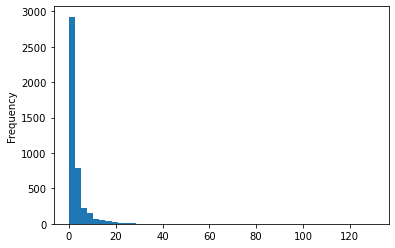

In [4]:
data['frequency'].plot(kind='hist', bins=50)
print(data['frequency'].describe())
print(sum(data['frequency'] == 0)/float(len(data)))

In [5]:
from lifetimes import BetaGeoFitter
bgf = BetaGeoFitter(penalizer_coef=0.0)
bgf.fit(data['frequency'], data['recency'], data['T'])
print(bgf)

<lifetimes.BetaGeoFitter: fitted with 4333 subjects, a: 0.00, alpha: 97.07, b: 10165.91, r: 0.95>


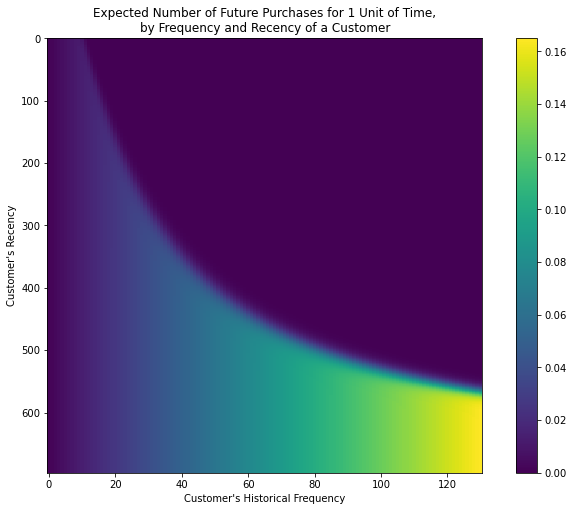

In [6]:
from lifetimes.plotting import plot_frequency_recency_matrix
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(12,8))
plot_frequency_recency_matrix(bgf)

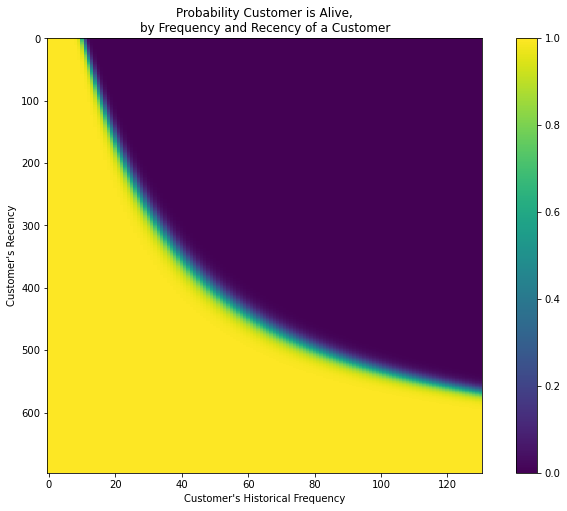

In [7]:
from lifetimes.plotting import plot_probability_alive_matrix
fig = plt.figure(figsize=(12,8))
plot_probability_alive_matrix(bgf)

In [8]:
t = 1
data['predicted_purchases'] = bgf.conditional_expected_number_of_purchases_up_to_time(t, data['frequency'], data['recency'], data['T'])
data.sort_values(by='predicted_purchases').tail(5)

,frequency,recency,T,monetary_value,predicted_purchases
CustomerID,,,,,
15311.0,88.0,688.0,696.0,671.460227,0.112159
14606.0,88.0,692.0,696.0,135.890114,0.112159
17841.0,110.0,694.0,696.0,362.595727,0.139899
12748.0,113.0,692.0,696.0,298.360885,0.143682
14911.0,130.0,695.0,696.0,1088.284385,0.165118


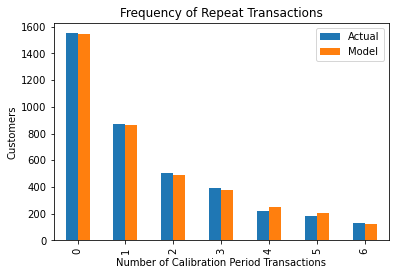

In [9]:
from lifetimes.plotting import plot_period_transactions
plot_period_transactions(bgf)

            frequency_cal  recency_cal  T_cal  frequency_holdout  \
CustomerID                                                         
12346.0               0.0          0.0  141.0                0.0   
12347.0               2.0        211.0  331.0                4.0   
12348.0               2.0        139.0  174.0                1.0   
12350.0               0.0          0.0  126.0                0.0   
12352.0               4.0         78.0  156.0                2.0   

            duration_holdout  
CustomerID                    
12346.0                184.0  
12347.0                184.0  
12348.0                184.0  
12350.0                184.0  
12352.0                184.0  


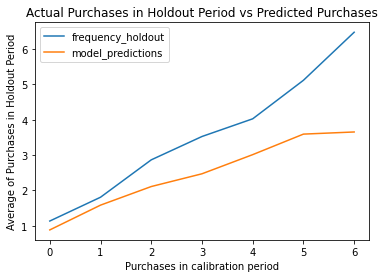

In [10]:
from lifetimes.utils import calibration_and_holdout_data
summary_cal_holdout = calibration_and_holdout_data(df, 'CustomerID', 'InvoiceDate',
                                        calibration_period_end='2011-06-08',
                                        observation_period_end='2011-12-09' )   
print(summary_cal_holdout.head())
from lifetimes.plotting import plot_calibration_purchases_vs_holdout_purchases
bgf.fit(summary_cal_holdout['frequency_cal'], summary_cal_holdout['recency_cal'], summary_cal_holdout['T_cal'])
plot_calibration_purchases_vs_holdout_purchases(bgf, summary_cal_holdout)

In [11]:
t = 10
individual = data.loc[12347]
bgf.predict(t, individual['frequency'], individual['recency'], individual['T'])

0.11258397192901222

In [12]:
from lifetimes.plotting import plot_history_alive
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(12,8))
id = 
days_since_birth = 365
sp_trans = df.loc[df['CustomerID'] == id]
plot_history_alive(bgf, days_since_birth, sp_trans, 'InvoiceDate')

SyntaxError: invalid syntax (<ipython-input-12-ac0ce4891184>, line 4)

In [ ]:
fig = plt.figure(figsize=(12,8))
id = 14729
days_since_birth = 365
sp_trans = df.loc[df['CustomerID'] == id]
plot_history_alive(bgf, days_since_birth, sp_trans, 'InvoiceDate')